# References
#### Roberto Rossini
### http://parnec.nuaa.edu.cn/xtan/data/ClosedEyeDatabases.html
### Based on my driving license plates detection project 

In [1]:
from __future__ import absolute_import, division, print_function

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib

# Check GPU
print("Tensorflow version:",tf.__version__)
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

/home/roxen/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/roxen/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/roxen/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/roxen/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:529: Futu

Tensorflow version: 1.13.1
Please install GPU version of TF


In [24]:
#print(device_lib.list_local_devices())

#def get_available_gpus():
#    local_device_protos = device_lib.list_local_devices()
#    return [x.name for x in local_device_protos if x.device_type == 'GPU']

#get_available_gpus()
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
#print(sess)



In [2]:
# Helper libraries
import scipy
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os

# from mlxtend.data import loadlocal_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder


In [3]:
def plot_history(histories, key='acc'):
    """
     Args:
         histories: list of tuples. Each tuple is composed by a string (name of the model) and the history (output of
                    model.fit())
                    e.g. histories = [('CNN_classifier', history)]
         key: string, key for the metric to visulize. e.g. 'acc' for accuracy
     Return:
         it plots the training and the validation accuracy during the training
     """
    plt.figure(figsize=(16, 10))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_' + key],
                       '--', label=name.title() + ' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title() + ' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_', ' ').title())
    plt.legend()

    plt.xlim([0, max(history.epoch)])
    plt.show()

In [4]:
def plot_images(images, labels, class_names, predictions=None):
    """
    Args:
        images: numpy tensor containing 9 test images
                [image_num, height, width, channels]
        labels: list of int, dataset labels of 9 examples (sparse representation)
        class_names: list of string, name assicuated to each class
        predictions: output of the model on 9 images from the dataset (contains the class PDF for each image)
    Return:
        It plots the provided 9 images with the label from the dataset,
        eventually with the model predictions
    """
    print(images.shape)
    assert len(images) == len(labels) == 9
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        # Plot image.
#         img = images[i].reshape(28,28)
        ax.imshow(images[i].squeeze(), cmap='binary')
        # Show true and predicted classes.
        if predictions is None:
            xlabel = "True: {}".format(class_names[labels[i]])
        else:
            predictions_in = np.argmax(predictions, axis=1)
            xlabel = "True: {}, Pred: {}".format(class_names[labels[i]], class_names[predictions_in[i]])
        ax.set_xlabel(xlabel)
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [5]:
def plot_image(i, predictions, labels, images, class_names):
    """
    Args:
        i: int, index of the selected image in the dataset
        predictions: output of the model on the whole dataset (contains the class PDF for each image)
        labels: list of int, dataset labels (sparse representation)
        images: numpy tensor containing the test images
               [image_num, height, width, channels]
        class_names: list of string, name assicuated to each class
    Return:
        it plots the selected image with the label and the predicted class
    """
    predictions_array, true_label, img = predictions[i], labels[i], images[i]

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
#     img.reshape(28,28)
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100 * np.max(predictions_array),
                                         class_names[true_label]),
               color=color)

In [6]:
def plot_example_errors(model, images, labels, class_names):
    """
    Args:
        model: Keras model, already trained
        images: numpy tensor containing the test images
               [image_num, height, width, channels]
        labels: list of int, dataset labels (sparse representation)
        class_names: list of string, name assicuated to each class
    Return:
        It prints the confusion matrix
    """
    # Get the predicted classifications for the test-set.
    predictions = model.predict(images)

    predictions_in = np.argmax(predictions, axis=1)
    correct = (predictions_in == labels)

    # Negate the boolean array.
    incorrect = (correct == False)
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = images[incorrect]
    # Get the predicted classes for those images.
    cls_pred = predictions[incorrect]
    # Get the true classes for those images.
    cls_true = labels[incorrect]
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                labels=cls_true[0:9],
                class_names = class_names,
                predictions=cls_pred[0:9])

In [7]:
def plot_value_array(i, predictions, labels, num_classes):
    """
    Args:
        i: int, index of the selected image in the dataset
        predictions: output of the model on the whole dataset (contains the class PDF for each image)
        labels: list of int, dataset labels (sparse representation)
        num_classes: int, number of classes
    Return:
        it plots the class PDF
    """
    predictions_array, true_label = predictions[i], labels[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(num_classes), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

In [8]:
def image_with_PDF(images, labels, predictions, num_classes, class_names):
    """
    Args:
        images: numpy tensor containing the test images
                [image_num, height, width, channels]
        labels: list of int, labels related to 'images' (sparse representation)
        predictions: output of the model on 'images' (contains the class PDF for each image)
        num_classes: int, number of classes
        class_names: list of string, name assicuated to each class
    Return:
        It plots 15 images with the label from the dataset,
        the model prediction and the predicted PDF
    """

    num_rows = 5
    num_cols = 3
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range(num_images):
      plt.subplot(num_rows, 2*num_cols, 2*i+1)
      plot_image(i, predictions, labels, np.squeeze(images), class_names)
      plt.subplot(num_rows, 2*num_cols, 2*i+2)
      plot_value_array(i, predictions, labels, num_classes)
    plt.show()

In [9]:
from os import listdir
import cv2

def load_dataset():

    img_shape = 48 # size of the eyes images
    
    #################
    # Build Dataset #
    #################

    # 4 different folders: 2 for closed eyes, 2 for opened eyes
    # Authoritatively I choose the labels: 0 closed, 1 open (or should I use one-hot encoding?)
    # In one-hot encoding: 10 Closed, 01 Open (maybe opposite LOL)
    closed_left_path = "dataset_B_Eye_Images/closedLeftEyes"
    closed_right_path = "dataset_B_Eye_Images/closedRightEyes"
    open_left_path = "dataset_B_Eye_Images/openLeftEyes"
    open_right_path = "dataset_B_Eye_Images/openRightEyes"
    # arrays to store train images and labels
    ims = []
    labs = []
    
    counter = 0
    # let's start with the closed ones
    for filename in listdir(closed_left_path):
        x = cv2.imread(closed_left_path + "/" + filename,0)
        ims.append(cv2.resize(x, (img_shape,img_shape), cv2.INTER_CUBIC))
        labs.append(0)
        counter+=1
    for filename in listdir(closed_right_path):
        x = cv2.imread(closed_right_path + "/" + filename,0)
        ims.append(cv2.resize(x, (img_shape,img_shape), cv2.INTER_CUBIC))
        labs.append(0)
        counter+=1
    # now the open ones
    for filename in listdir(open_left_path):
        x = cv2.imread(open_left_path + "/" + filename,0)
        ims.append(cv2.resize(x, (img_shape,img_shape), cv2.INTER_CUBIC))
        labs.append(1)
        counter+=1
    for filename in listdir(open_right_path):
        x = cv2.imread(open_right_path + "/" + filename,0)
        ims.append(cv2.resize(x, (img_shape,img_shape), cv2.INTER_CUBIC))
        labs.append(1)
        counter+=1

    np_ims = np.zeros((counter, img_shape, img_shape))
    for i in range(counter):
        np_ims[i] = ims[i]
    np_ims = np.array(np_ims).reshape((-1, img_shape, img_shape, 1), order="F")
    np_labs = np.array(labs).reshape((-1))

    ################
    # Train & Test #
    ################

    # now that I built the dataset, I have to split it into train and test:
    # shuffle the 2 arrays
    perm = np.random.permutation(np_labs.shape[0])
    np_ims = np_ims[perm]
    np_labs = np_labs[perm]

    # train-test: 80-20
    train_size = round(counter/100*90)
    test_size = counter - train_size

    train_images = np_ims[:train_size]
    train_labels = np_labs[:train_size]
    test_images = np_ims[train_size:]
    test_labels = np_labs[train_size:]

    # little check
    print(train_images.shape)
    print(train_labels.shape)
    print(test_images.shape)
    print(test_labels.shape)
        
    return train_images, train_labels, test_images, test_labels

In [10]:
def main():
    img_shape = 48 # size of the eyes images
    x_train, y_train, x_test, y_test = load_dataset()
    batch_size = 512
    epochs = 20
    
    # train set
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(y_train)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded_train = onehot_encoder.fit_transform(integer_encoded)
    
    # test set
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(y_test)    
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded_test = onehot_encoder.fit_transform(integer_encoded)
    
    print("Size of:")
    print("- Training-set:\t\t{}".format(x_train.shape[0]))
    print("- Test-set:\t\t{}".format(x_test.shape[0]))

    num_classes = 2
    class_names = ['Closed', 'Open']

    # Data preprocessing: image normalization
    x_train = x_train / 255.0

    x_test = x_test / 255.0

    # Plot images
    plot_images(x_test[:9], y_test[:9], class_names)

    # Create Keras model and evaluate its performance
    img_rows, img_cols = img_shape, img_shape

    if K.image_data_format() == "channel_first":
        x_train = x_train.reshape(x_train_shape[0], 1, img_rows, img_cols)
        x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)
    
    # building the network
    model = Sequential()
    #model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    #model.add(Conv2D(32, (3, 3), activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.25))
    #model.add(Flatten())
    #model.add(Dense(64, activation='relu'))
    #model.add(Dropout(0.25))
    #model.add(Dense(units=num_classes, activation='softmax'))
    #model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
    
    #Conv-Pool-Conv-Pool or Conv-Conv-Pool-Conv-Conv-Pool or trend in the Number of channels 
    # 32–64–128 or 32–32-64–64 or trend in filter sizes, Max-pooling parameters etc.
    model.add(Conv2D(16, kernel_size=(3, 3),
        activation='relu',
        input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(units=num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
    
    model.summary()
   
    # fit the model and save the history information
    history = model.fit(x_train, onehot_encoded_train,
        epochs=epochs,
        verbose=1,
        batch_size=batch_size,
        validation_data=(x_test, onehot_encoded_test))
    score = model.evaluate(x_test, onehot_encoded_test, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    predictions = model.predict(x_test, verbose=1)

    # serialize model to JSON --> save network model
    #model_json = model.to_json()
    #with open("naive_model.json", "w") as json_file:
     #   json_file.write(model_json)
    # serialize weights to HDF5 --> save network weights
    #model.save_weights("naive_model_weights.h5")
    #print("Saved model to disk")
    
    # fashion utilities
    plot_example_errors(model, x_test, y_test, class_names)
    image_with_PDF(x_test, y_test, predictions, num_classes, class_names)
    
    plot_history([('CNN_classifier', history)])
    
    

    keras.backend.clear_session()

(4361, 48, 48, 1)
(4361,)
(485, 48, 48, 1)
(485,)
Size of:
- Training-set:		4361
- Test-set:		485
(9, 48, 48, 1)


/home/roxen/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/roxen/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In cas

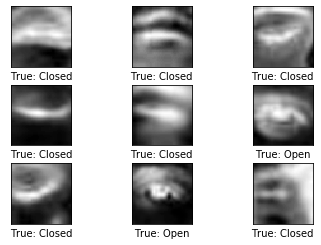

NameError: name 'K' is not defined

In [11]:
# execute code
if __name__ == '__main__':
    main()